In [4]:
# import packages
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # import plotting module
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # import preprocessing modules
from sklearn.compose import ColumnTransformer # import column transformer class
import sklearn.model_selection as train_test_split # import method for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef # import metrics
from sklearn.tree import DecisionTreeClassifier # import decision tree classifier
from sklearn.ensemble import RandomForestClassifier # import random forest classifier
from sklearn.neighbors import KNeighborsClassifier # import k-nearest neighbors classifier
import torch # import pytorch
import torch.nn as nn # import pytorch for neural networks
from torch.utils.data import DataLoader, Dataset # import dataset and dataloader classes


# import modules
import classify

# check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1 - Dataset

In [5]:
# read in data
data = pd.read_csv('./Data/ai4i2020.csv')
data_columns = ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
label_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# identify features and labels
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
bin_labels = label_columns.copy()
display(data.head(3))
print('Shape of data:', data.shape)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


Shape of data: (10000, 14)


### Exploratory Data Analysis

#### General Statistics

In [6]:
print('Numeric Feature Columns')
feature_stats = data[numeric_features].describe().drop(['count', '25%', '50%', '75%'])
display(feature_stats)

print('Label Columns')
label_stats = data[bin_labels].describe().drop(['count', 'std', 'min', 'max', '25%', '50%', '75%']).rename(index={'mean': 'Failure Rate'})
label_stats.loc['Failure Type Proportion'] = label_stats.loc['Failure Rate'] / label_stats.loc['Failure Rate', 'Machine failure']
display(label_stats)

Numeric Feature Columns


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


Label Columns


,Machine failure,TWF,HDF,PWF,OSF,RNF
Failure Rate,0.0339,0.004600,0.011500,0.009500,0.009800,0.001900
Failure Type Proportion,1.0000,0.135693,0.339233,0.280236,0.289086,0.056047


#### Visualizations

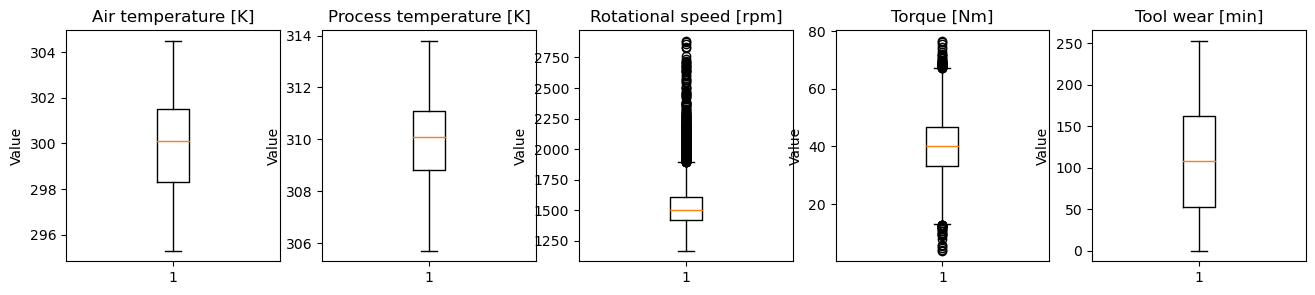

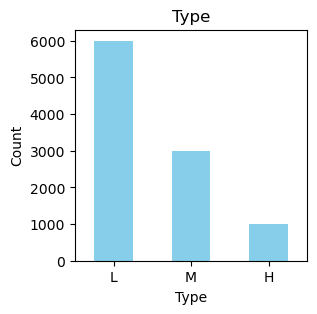

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
for idx in range(len(numeric_features)):
    axes[idx].boxplot(data[numeric_features[idx]])
    axes[idx].set_title(numeric_features[idx])
    axes[idx].set_ylabel('Value')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
data[categorical_features[0]].value_counts().plot(kind='bar', ax=ax, color='skyblue')
ax.set_title(categorical_features[0])
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
plt.show()



#### Correlations

In [8]:
print('Correlation Matrix for Features')
data[numeric_features].corr()

Correlation Matrix for Features


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


### Data Restructuring
Multi-label versus multi-class classification? (problem: hardly any RNF failures)

In [9]:
def determine_failure_mode(event, specify_multiple):
    failure_modes = [failure for failure in bin_labels[1:] if event[failure] == 1]
    if not failure_modes:
        return 'No failure'
    elif specify_multiple:
        return '_'.join(failure_modes)
    else:
        return failure_modes[0] if len(failure_modes) == 1 else 'Multiple failures'

In [10]:
specify_multiple = False # what label to assign to events with multiple failures
data['Failure Mode'] = data.apply(lambda event: determine_failure_mode(event = event, specify_multiple = specify_multiple), axis=1)
categorical_labels = ['Failure Mode']
labels = bin_labels + categorical_labels
features = numeric_features + categorical_features
display(data['Failure Mode'].value_counts())

No failure           9652
HDF                   106
PWF                    80
OSF                    78
TWF                    42
Multiple failures      24
RNF                    18
Name: Failure Mode, dtype: int64

### Data Encoding and Normalization

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)
label_encoder = LabelEncoder()

In [12]:
X = pd.DataFrame(preprocessor.fit_transform(data[features]), columns = preprocessor.get_feature_names_out())
# y = data[labels]
# fit transform to categorical labels and combine back with numeric labels
y_categorical_encoded = pd.DataFrame(label_encoder.fit_transform(data['Failure Mode']), columns = ['Failure Mode'])
y = pd.concat([data[bin_labels], y_categorical_encoded], axis=1)

#### Final Data Format

In [13]:
display(X.head(3))
display(y.head(3))
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)
print('Labels: ', labels)

,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],cat__Type_H,cat__Type_L,cat__Type_M
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0


,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,2
2,0,0,0,0,0,0,2


Numeric features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical features: ['Type']
Labels:  ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure Mode']


### Train Test Split

In [14]:
X_remainder, X_test, y_remainder, y_test = train_test_split.train_test_split(X, y, test_size=0.1, stratify=data['Failure Mode'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split.train_test_split(X_remainder, y_remainder, test_size=0.2, stratify=y_remainder['Failure Mode'], random_state=42)
print('Shape of training data:', X_train.shape)
print('Shape of validation data:', X_val.shape)
print('Shape of test data:', X_test.shape)
display(X_train.head(3), y_train.head(3))

Shape of training data: (7200, 8)
Shape of validation data: (1800, 8)
Shape of test data: (1000, 8)


,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],cat__Type_H,cat__Type_L,cat__Type_M
7604,0.197519,0.872464,0.559051,-0.540397,-1.318927,0.0,1.0,0.0
4593,1.497416,0.805063,-0.723893,0.191915,-0.156337,0.0,1.0,0.0
7976,0.597488,1.613874,-0.801986,0.783783,-0.282022,1.0,0.0,0.0


,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
7604,0,0,0,0,0,0,2
4593,0,0,0,0,0,0,2
7976,0,0,0,0,0,0,2


## 2 - Classifiers

### Naive Classifier
Baseline 1

In [15]:
def naive_classify(data):
    labels = [label_encoder.transform(['No failure']) for i in range(data.shape[0])]
    return labels

In [16]:
importlib.reload(classify)

naive_labels = naive_classify(X_test)
naive_accuracy = accuracy_score(naive_labels, y_test['Failure Mode'])
naive_precision = precision_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_recall = recall_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_f1 = f1_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_confusion = confusion_matrix(naive_labels, y_test['Failure Mode'])
naive_matthews = matthews_corrcoef(naive_labels, y_test['Failure Mode'])

print('Naive Classifier')
print('Accuracy:', naive_accuracy)
print('Precision:', naive_precision)
print('Recall:', naive_recall)
print('F1 Score:', naive_f1)
print('Confusion Matrix:')
print(naive_confusion)
print('Matthews Correlation Coefficient:', naive_matthews)

Naive Classifier
Accuracy: 0.965
Precision: 1.0
Recall: 0.965
F1 Score: 0.9821882951653944
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 11   2 965   8   8   2   4]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Matthews Correlation Coefficient: 0.0


/Users/minghui/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree
Baseline 2

In [17]:
importlib.reload(classify)

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train['Failure Mode'])
decision_tree_labels = decision_tree.predict(X_test)
decision_tree_accuracy = accuracy_score(decision_tree_labels, y_test['Failure Mode'])
decision_tree_precision = precision_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_recall = recall_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_f1 = f1_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_confusion = confusion_matrix(decision_tree_labels, y_test['Failure Mode'])
decision_tree_matthews = matthews_corrcoef(decision_tree_labels, y_test['Failure Mode'])

print('Decision Tree Classifier')
print('Accuracy:', decision_tree_accuracy)
print('Precision:', decision_tree_precision)
print('Recall:', decision_tree_recall)
print('F1 Score:', decision_tree_f1)
print('Confusion Matrix:')
print(decision_tree_confusion)
print('Matthews Correlation Coefficient:', decision_tree_matthews)

Decision Tree Classifier
Accuracy: 0.979
Precision: 0.9789834196891192
Recall: 0.979
F1 Score: 0.9785240165631469
Confusion Matrix:
[[ 11   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0]
 [  0   0 957   2   4   2   2]
 [  0   1   1   5   0   0   1]
 [  0   0   0   0   4   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0   4   1   0   0   1]]
Matthews Correlation Coefficient: 0.6850840182907083


In [18]:
importlib.reload(classify)

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train['Failure Mode'])
random_forest_labels = random_forest.predict(X_test)
random_forest_accuracy = accuracy_score(random_forest_labels, y_test['Failure Mode'])
random_forest_precision = precision_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_recall = recall_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_f1 = f1_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_confusion = confusion_matrix(random_forest_labels, y_test['Failure Mode'])
random_forest_matthews = matthews_corrcoef(random_forest_labels, y_test['Failure Mode'])

print('Random Forest Classifier')
print('Accuracy:', random_forest_accuracy)
print('Precision:', random_forest_precision)
print('Recall:', random_forest_recall)
print('F1 Score:', random_forest_f1)
print('Confusion Matrix:')
print(random_forest_confusion)
print('Matthews Correlation Coefficient:', random_forest_matthews)

Random Forest Classifier
Accuracy: 0.985
Precision: 0.9928522020725389
Recall: 0.985
F1 Score: 0.9885893642678806
Confusion Matrix:
[[ 10   0   1   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  1   0 963   3   3   2   4]
 [  0   0   0   5   0   0   0]
 [  0   0   1   0   5   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Matthews Correlation Coefficient: 0.7549800149511631


/Users/minghui/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### k-NN

In [19]:
importlib.reload(classify)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train['Failure Mode'])
knn_labels = knn.predict(X_test)
knn_accuracy = accuracy_score(knn_labels, y_test['Failure Mode'])
knn_precision = precision_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_recall = recall_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_f1 = f1_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_confusion = confusion_matrix(knn_labels, y_test['Failure Mode'])
knn_matthews = matthews_corrcoef(knn_labels, y_test['Failure Mode'])

print('K-Nearest Neighbors Classifier')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('F1 Score:', knn_f1)
print('Confusion Matrix:')
print(knn_confusion)
print('Matthews Correlation Coefficient:', knn_matthews)

K-Nearest Neighbors Classifier
Accuracy: 0.969
Precision: 0.983540956194065
Recall: 0.969
F1 Score: 0.9752398059610989
Confusion Matrix:
[[  3   0   4   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  8   0 959   6   6   2   3]
 [  0   0   0   2   0   0   0]
 [  0   0   1   0   2   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   1]]
Matthews Correlation Coefficient: 0.41457363734590097


/Users/minghui/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network

In [20]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data.to_numpy(), dtype=torch.float32)
    self.labels = torch.tensor(targets.to_numpy(), dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.Tanh(),
        nn.Linear(k, size_out),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return predictions, accuracy, avg_loss

In [21]:
y_train

,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
7604,0,0,0,0,0,0,2
4593,0,0,0,0,0,0,2
7976,0,0,0,0,0,0,2
1576,0,0,0,0,0,0,2
5767,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...
9310,0,0,0,0,0,0,2
6195,0,0,0,0,0,0,2
4228,0,0,0,0,0,0,2
7230,0,0,0,0,0,0,2


In [22]:
importlib.reload(classify)

batch_size = 32
epochs = 100
loss_fun = nn.BCEWithLogitsLoss()
lr = 0.001

train_data = Data(X_train, y_train['Failure Mode'])
valid_data = Data(X_val, y_val['Failure Mode'])
test_data = Data(X_test, y_test['Failure Mode'])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = FeedForward(size_in=X_train.shape, size_out=len(y_train['Failure Mode'].unique()), k=64).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

training_loss = []
validation_loss = []
for epoch in range(epochs):
    avg_train_loss = train_model(model, train_loader, loss_fun, optimizer, device)    
    _, accuracy, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
    training_loss.append(avg_train_loss)
    validation_loss.append(avg_valid_loss)

# Plot training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type tuple at pos 2

## 3 - Comparison

The following section shows the performance comparison of different models. The metrics we used for comparison are: Accuracy, F1 Score and Matthews Correlation Coefficient.

In [23]:
naive_results = {
    "Model": "naive",
    "Matthews Correlation Coefficient": naive_matthews,
    "Accuracy": naive_accuracy,
    "F1 Score": naive_f1
}

decision_tree_results = {
    "Model": "decision_tree",
    "Matthews Correlation Coefficient": decision_tree_matthews,
    "Accuracy": decision_tree_accuracy,
    "F1 Score": decision_tree_f1
}

knn_results = {
    "Model": "knn",
    "Matthews Correlation Coefficient": knn_matthews,
    "Accuracy": knn_accuracy,
    "F1 Score": knn_f1
}

random_forest_results = {
    "Model": "random_forest",
    "Matthews Correlation Coefficient": random_forest_matthews,
    "Accuracy": random_forest_accuracy,
    "F1 Score": random_forest_f1
}

results = [naive_results, decision_tree_results, knn_results, random_forest_results]
results_df = pd.DataFrame(results)
print(results_df)

           Model  Matthews Correlation Coefficient  Accuracy  F1 Score
0          naive                          0.000000     0.965  0.982188
1  decision_tree                          0.685084     0.979  0.978524
2            knn                          0.414574     0.969  0.975240
3  random_forest                          0.754980     0.985  0.988589
